In [ ]:
!git clone https://github.com/zuoxingdong/mazelab.git
%cd mazelab
!pip install -e .

Cloning into 'mazelab'...
remote: Enumerating objects: 328, done.
remote: Total 328 (delta 0), reused 0 (delta 0), pack-reused 328
Receiving objects: 100% (328/328), 11.77 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/mazelab
Obtaining file:///content/mazelab
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mazelab


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install gym

In [19]:
import numpy as np
import random
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color

from mazelab import BaseEnv
from mazelab import VonNeumannMotion

from abc import ABC
from abc import abstractmethod

import gym
from gym.utils import seeding
from gym.spaces import Box
from gym.spaces import Discrete

import pygame
import collections


def create_structures():
  trash_cans = {'plastic': [(16,1),(18,27),(2,28)], 'paper': [(18,7),(18,26),(7,28)], 'general': [(15,12),(1,20)], 'edible': [(1,1),(11,6),(12,28)]}
  fullness = {'(16,1)': 0, '(18,27)': 0, '(2,28)': 0, '(18,7)': 0, '(18,26)': 0, '(7,28)': 0, '(15,12)': 0, '(1,20)': 0, '(1,1)': 0, '(11,6)': 0, '(12,28)': 0}
  return trash_cans, fullness


def update_fullness(fullness, coords):
  fullness[coords] += 1


def is_full(fullness, coords):
  if fullness[coords] == 5: return True
  else: return False


def choices(n):
  doors = [(13,3), (2,7), (9,7), (13,9), (14,21), (12,22), (7,22), (2,22), (5,26)]
  random_closed = random.sample(doors, n)
  return random_closed


def generate_matrix(agent, goal, random_closed):
  x = np.array([[1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 4, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
                [1, 1, 1, 1, 1, 1 ,1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1],
                [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 7, 6, 0, 1],
                [1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=np.uint8)

  x[agent[0], agent[1]] = 2
  x[goal[0], goal[1]] = 8
  for i in random_closed:
    x[i[0], i[1]] = 9

  return x


def bfs(grid, start):
  queue = collections.deque([[start]])
  seen = set([start])
  while queue:
    path = queue.popleft()
    x, y = path[-1]
    if grid[y][x] == 8:
      return path
    for x2, y2 in ((x+1,y), (x-1,y), (x,y+1), (x,y-1)):
      if 0 <= x2 < 30 and 0 <= y2 < 20 and grid[y2][x2] != 1 and grid[y2][x2] != 3 and grid[y2][x2] != 4 and grid[y2][x2] != 5 and grid[y2][x2] != 6 and grid[y2][x2] != 7 and grid[y2][x2] != 9 and (x2, y2) not in seen:
        queue.append(path + [(x2, y2)])
        seen.add((x2, y2))


In [73]:
start = (15,17)
random_closed = choices(3)

print(random_closed)

#TODO ricerca del goal più vicino in base alla richiesta

#richiesta ---> ragazzino chiede dove buttare


#ESEMPIO PLASTICA
trash_cans, fullness = create_structures()

for i in trash_cans['general']:
  x = generate_matrix(start, i, random_closed)
  path = bfs(x, start)
  print(i, path)

print(x)

[(9, 7), (12, 22), (13, 3)]
(15, 12) [(15, 17), (14, 17), (13, 17), (12, 17), (12, 16), (12, 15)]
(1, 20) [(15, 17), (16, 17), (17, 17), (17, 16), (17, 15), (17, 14), (17, 13), (18, 13), (19, 13), (20, 13), (20, 12), (20, 11), (20, 10), (20, 9), (20, 8), (20, 7), (20, 6), (20, 5), (20, 4), (20, 3), (20, 2), (20, 1)]
[[1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1]
 [1 4 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 8 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 6 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 7 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 9 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 

In [86]:
class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape

    def make_objects(self):
        free = Object('free', 0, [255, 255, 255], False, np.stack(np.where(x == 0), axis=1))
        walls = Object('obstacle1', 1, [160, 160, 160], True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, [255, 0, 0], False, [])
        garden = Object('obstacle2', 3, [51, 175, 2], True, np.stack(np.where(x == 3), axis=1))
        green = Object('obstacle3', 4, [97, 255, 34], True, np.stack(np.where(x == 4), axis=1))
        black = Object('obstacle4', 5, [0, 0, 0], True, np.stack(np.where(x == 5), axis=1))
        blue = Object('obstacle5', 6, [0, 0, 255], True, np.stack(np.where(x == 6), axis=1))
        yellow = Object('obstacle6', 7, [255, 190, 0], True, np.stack(np.where(x == 7), axis=1))
        goal = Object('goal', 8, [255, 0, 0], False, [])
        door = Object('obstacle7', 9, [110, 89, 69], True, np.stack(np.where(x == 9), axis=1))

        return free, walls, agent, garden, green, black, blue, yellow, goal, door


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass


    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None



class Env(BaseEnv):
    def __init__(self):
        super().__init__()

        self.maze = Maze()
        self.motions = VonNeumannMotion()

        self.observation_space = Box(low=0, high=100, shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))

        self.window = None

    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]

        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}

    def reset(self):
        start_idx = np.stack(np.where(x == 2), axis=1)
        goal_idx = np.stack(np.where(x == 8), axis=1)

        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()

    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable

    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out

    def plot(self, x, render_mode = "human", window_size_x=1200, window_size_y=800):
        if self.window is None:
          pygame.init()
          pygame.display.init()
          self.window = pygame.display.set_mode((window_size_x, window_size_y))

        canvas = pygame.Surface((window_size_y, window_size_x))
        canvas.fill((255, 255, 255))
        pix_square_size_x = (
            window_size_x / 30
        )  # The size of a single grid square in pixels
        pix_square_size_y = (
            window_size_y / 20
        )  # The size of a single grid square in pixels

        print(pix_square_size_x, pix_square_size_y)

        i = 0
        for r in x:
          j = 0
          for c in r:
            #print(c)
            if c == 0:
              pygame.draw.rect(canvas, (255, 255, 255),
                               pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 1:
              pygame.draw.rect(canvas, (160, 160, 160),
                               pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 2:
              pygame.draw.rect(canvas, (255, 0, 0),
                               pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 3:
              pygame.draw.rect(canvas, (51, 175, 2),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 4:
              pygame.draw.rect(canvas, (97, 255, 34),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 5:
              pygame.draw.rect(canvas, (0, 0, 0),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 6:
              pygame.draw.rect(canvas, (0, 0, 255),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 7:
              pygame.draw.rect(canvas, (255, 190, 0),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            elif c == 8:
              if (i,j) in trash_cans['plastic']:
                pygame.draw.rect(canvas, (0, 0, 255),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
              if (i,j) in trash_cans['paper']:
                pygame.draw.rect(canvas, (255, 190, 0),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
              if (i,j) in trash_cans['general']:
                pygame.draw.rect(canvas, (0, 0, 0),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
              if (i,j) in trash_cans['edible']:
                pygame.draw.rect(canvas, (97, 255, 34),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
              pygame.draw.ellipse(canvas, (255, 0, 0), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)), width= 20)

            else:
              pygame.draw.rect(canvas, (110, 89, 69),
                              pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                                (pix_square_size_x, pix_square_size_y)))
            #print(m[i][j])
            j+=1
          i+=1

        if self.render_mode == "human":
          # The following line copies our drawings from `canvas` to the visible window
          self.window.blit(canvas, canvas.get_rect())
          pygame.event.pump()
          pygame.display.update()

          # We need to ensure that human-rendering occurs at the predefined framerate.
          # The following line will automatically add a delay to keep the framerate stable.
          self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
          return np.array(pygame.surfarray.pixels3d(canvas))

    def get_image(self):
        return self.maze.to_rgb()


In [87]:
gym.envs.register(id='env', entry_point=Env, max_episode_steps=200)

100.0 100.0
40.0 40.0


array([[[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]],

       ...,

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [160, 160, 160],
        [160, 160, 160],
        [160, 160, 160]]

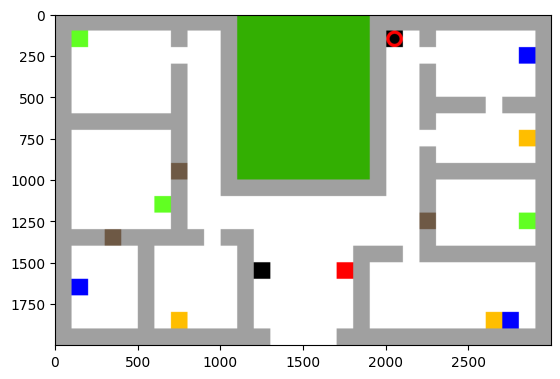

In [88]:
import matplotlib.pyplot as plt

env = gym.make('env')
env.reset()
img = env.plot(x, 'rgb_array', window_size_x=3000, window_size_y=2000)
plt.imshow(img)

env.plot(x, "human", window_size_x=1200, window_size_y=800)

In [28]:
from mazelab.solvers import dijkstra_solver

impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
print(motions)
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)

rewards = 0.0
env.reset()
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
env.close()
print(rewards)


VonNeumannMotion(north=[-1, 0], south=[1, 0], west=[0, -1], east=[0, 1])
[0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3]
0.7699999999999999
